In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import os

from spectralmask import DATADIR
from spectralmask.spectrum import Spectrum
from spectralmask.mask import Mask
from spectralmask.fit import gaussian_fit

### Radial Velocities

The "simple" way to measure a radial velocity is to compare the wavelength of an observed spectral line to the wavelength measured in a laboratory setting. With that measurement in hand, the Doppler equation dictates how to convert the difference in wavelength to a velocity. Using a single line can be limited if, for example, the spectrum is low signal to noise or there are multiple processes contributing to the line profile. 

One can use "all the information" present in a spectrum to estimate the redshift/Doppler shift via a cross-correlation with a template spectrum. The (discrete) cross-correlation is the sum of the observed spectrum multiplied by the template. 
$$CC = \sum f(m) g(m - n)$$

where the sum is over all pixels $m$, $f$ is the spectrum, and $g$ is the shifted template (in practice we use interpolation to place the Doppler-shifted template onto the same wavelength grid as the primary observations).

The cross-correlation function (CCF) is the value of the cross-correlation at different velocity shifts for the template. The peak of the CCF corresponds to your estimate for the RV of the observation.

### Measuring RVs with a Spectral Mask

The procedure to measure the cross-correlation function is largely the same as the procedure explained above, except that instead of a template we have a mask. The mask file consists of three columns. The first column defines the "left" or "blue" edge of a mask region, the second column defines the "right" or "red" edge of a mask region, and the third column defines the mask value. 

In order to calculate the cross-correlation (and eventually the CCF), we need to "interpolate" the mask onto the wavelength grid of the observed spectrum.

To determine the value of the mask in each pixel of the ELODIE spectrum, we calculate the fractional coverage of the mask with the givel pixel, and then multiply that fraction by the mask value. 

# Example Analysis

The example data included in this package are spectra obtained with the ELODIE spectrograph and are continuum normalized (but not corrected for NaNs or the motion of the Solar system barycenter). The file `G2_mask.csv` provided is an example of a spectral mask. 

### Preprocessing

In [2]:
# Instantiate Spectrum object based on .fits file
s = Spectrum(name="normed_19940914_0022_s1d.fits",path=DATADIR+"fits/")

# Create wavelength array based on the reference pixel value, pixel size,
# and number of pixels from the .fits file metadata
wv1 = s.make_wv()

# Interpolate over NaN values in the spectrum
spec1 = s.interpolate_nan(wv1)

### Cross-correlation function between spectrum and mask

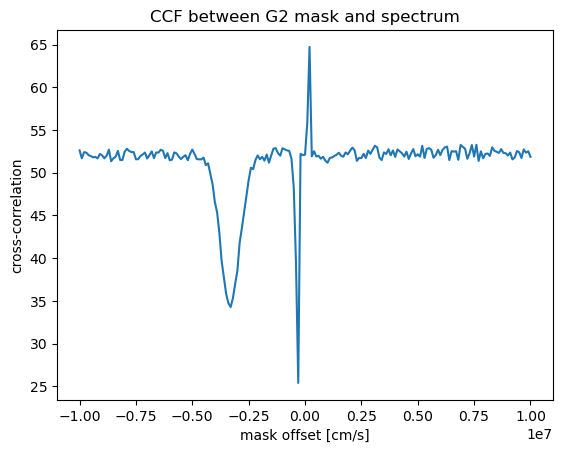

In [3]:
# Instantiate the mask object based on the .csv file and above spectrum
m = Mask(wv1,spec1,mask=DATADIR+"G2_mask.csv")

# Interpolate the spectrum and mask over all wavelength values
# and calculate the CCF 
offsets,CCF = m.CCF()

# Plot the CCF
plt.figure()
plt.plot(offsets,CCF)
plt.xlabel("mask offset [cm/s]")
plt.ylabel("cross-correlation")
plt.title("CCF between G2 mask and spectrum")
plt.show()

note: The Gaussian is upside-down because the mask values are positive and we cross-correlate them with absorption lines, which are negative features. The other narrow spikes are an artifact caused by a remaining bug but should not affect the fitting process. 

### Estimate the RV

Fit a Gaussian model to the CCF and use the uncertainty on the mean of the Gaussian as the uncertainty of the RV.

In [4]:
# Fit a Gaussian to the CCF and return the mean and std
mean, std = gaussian_fit(offsets,CCF)
print('The star\'s RV is {0:8.2f} +/- {1:8.2f} cm/s'.format(mean,std))

The star's RV is -3321048.29 +/- 431647.40 cm/s


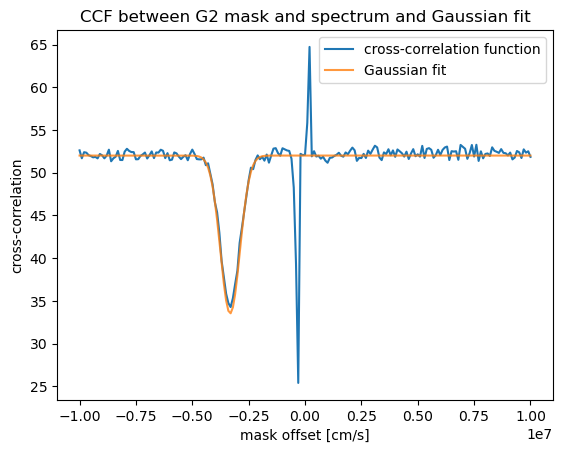

In [5]:
# Plot the CCF and Gaussian fit
plt.figure()
plt.plot(offsets,CCF, label = "cross-correlation function")
plt.plot(offsets,norm.pdf(offsets, mean,std)*-2e7+52,alpha=0.8,
        label = "Gaussian fit")
plt.xlabel("mask offset [cm/s]")
plt.ylabel("cross-correlation")
plt.legend()
plt.title("CCF between G2 mask and spectrum and Gaussian fit")
plt.show()